# Evaluation of Molecular Dynamics Named Entities Recognition (MDNER)

The objective of this notebook is to evaluate our MDNER obtained with [SpaCy v3](https://spacy.io/) by assessing the annotated entities and its performance. 

## Prerequise packages

In [56]:
import pandas as pd
import spacy
from matplotlib import pyplot as plt
import os
import seaborn as sns
import json
import glob
from spacy.training import Example
import re

## Corpus composition

The evaluation of the distribution of entities in our corpus will allow us to identify the most and least abundant entities.

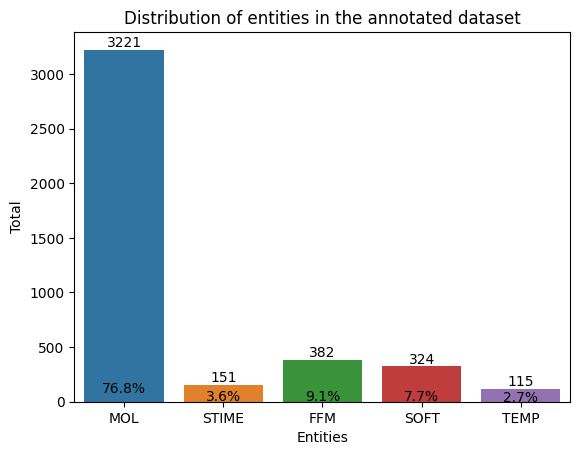

In [8]:
path = "../annotations/"
name_ents = ["MOL", "STIME", "FFM", "SOFT", "TEMP"]
n_ents = dict.fromkeys(name_ents, 0)
perc_ents = dict.fromkeys(name_ents, 0)
total = 0

# Get numbers and percentage for each entity
for json_name in glob.glob(path + "*.json"):
    with open(path + json_name, "r") as json_file:
        annotations = json.load(json_file)["annotations"][0][1]
        for _, _, label in annotations["entities"]:
            n_ents[label] += 1
            total += 1
for label in name_ents:
    perc_ents[label] = float(n_ents[label] / total) * 100

# Create a pd.DataFrame that will contain the percentage and total number of sample entities.
df_perc = pd.DataFrame.from_dict(perc_ents, orient="index", columns=["Percentage"])
df_n = pd.DataFrame.from_dict(n_ents, orient="index", columns=["Total"])
df = pd.concat([df_perc, df_n], axis=1)

# Display a barplot for each entities
ax = sns.barplot(x = df.index, y = 'Total', data=df)
plt.xlabel("Entities")
plt.title("Distribution of entities in the annotated dataset")

for i, p in enumerate(ax.patches):
    # Add the number of sample entities for each dedicated bar
    ax.text(p.get_x() + p.get_width()/2,
            p.get_height(),
            f"{int(df.iloc[i]['Total'])}",
            ha='center',
            va='bottom')
    # Add a percentage in each dedicated bar
    ax.text(i, df.iloc[i]['Percentage'] + 1, str(round(df.iloc[i]['Percentage'], 1))+'%', ha='center')

As shown in the figure above, there is a large number of "MOL" (molecules) entities which represent more than 76% of all entities. The entities "STIME" (simulation time) and "TEMP" (temperature) are less present in the corpus with a percentage of 3.6% and 2.7% respectively. 

In order to learn each entities, more than 100 entities samples must be present. In our case, this condition is correct.

The distribution of these entities allows us to say that the NER should expect an overrepresentation of the entitie "MOL" in a text compared to the entities "STIME" and "TEMP" for example.

## Evaluation of the model using metrics

In order to evaluate the performance of our model, we will base on 3 metrics, namely the precision score, the recall score and the f1 score:
* Precison score tells us that the model predicts correctly but not everything.
* Recall score tells us that the model predicts many entities but not necessarily correct.
* F1 score is a [harmonic mean](https://en.wikipedia.org/wiki/Harmonic_mean) of the precision score and the recall score.

These scores are obtained with the help of a confusion matrix and using the formulas available [here](https://en.wikipedia.org/wiki/F-score).
For the evaluation of our model, we will use the accuracy score as we prefer quality to quantity.

For the evaluation, we choose to compare two models, namely a model with only molecular entities and a model with all entities. We want to verify that the model with only molecular entities has a better performance in terms of classification. The hyperparameters used to design these models are: 
* *Batch size* of 32
* *Learning rate* of 0.001
* The fine-tuned model is [*allenai/biomed_roberta_base*](https://huggingface.co/allenai/biomed_roberta_base)

### During the training

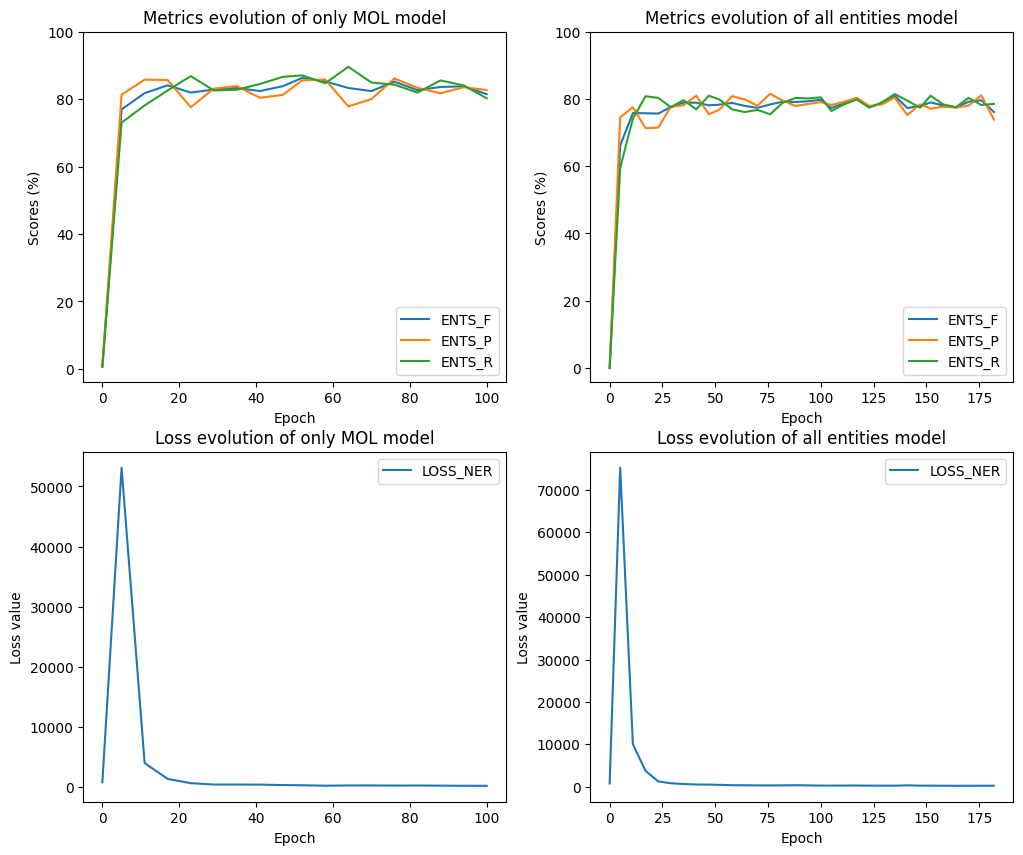

In [9]:
# Paths of different models
paths = ["../results/colab/only_mol/", "../results/colab/all_ents/"]

epoch = [[], []]
fscore = [[], []]
precision = [[], []]
recall = [[], []]
loss_validation = [[], []]

# Create lists that will contain all scores, loss values and epochs
for i in range(len(paths)) :
    with open(paths[i] + "metrics_train.txt", "r") as f:
        for line in f:
            if line.strip()[0].isdigit():
                epoch[i].append(int(line.split()[0]))
                fscore[i].append(float(line.split()[-4]))
                precision[i].append(float(line.split()[-3]))
                recall[i].append(float(line.split()[-2]))
                loss_validation[i].append(float(line.split()[3]))

# Create four subplot for metrics evolution and the loss evolution
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for i in range(len(paths)) :
    # Create a plot for metrics evolution
    sns.lineplot(x=epoch[i], y=fscore[i], label="ENTS_F", ax=axs[0][i])
    sns.lineplot(x=epoch[i], y=precision[i], label="ENTS_P", ax=axs[0][i])
    sns.lineplot(x=epoch[i], y=recall[i], label="ENTS_R", ax=axs[0][i])
    title = "only MOL model" if i == 0 else "all entities model"
    axs[0][i].set_title("Metrics evolution of " + title)
    axs[0][i].set_xlabel("Epoch")
    axs[0][i].set_ylabel("Scores (%)")
    axs[0][i].set_ylim(top=100)

    # Create a plot for loss evolution
    sns.lineplot(x=epoch[i], y=loss_validation[i], label="LOSS_NER", ax=axs[1][i])
    axs[1][i].set_title("Loss evolution of "+ title)
    axs[1][i].set_xlabel("Epoch")
    loss_ylabel = axs[1][i].set_ylabel("Loss value")

When designing the models, the resulting model metrics are better on the model with only MOL entities with a difference about 4% for the precision score, 7% for the recall score and 5% for the f1 score.

### Benchmark

The validation dataset is used for the benchmark. It consists of 17 texts with annotated entities.

In [31]:
def get_confusion_matrix(type_model: str, only_mol: bool):
    path = "../results/colab/" + type_model
    tp, fp, fn, tn = 0, 0, 0, 0
    ner = spacy.load(path + "/models/model-best/")
    nlp = spacy.blank("en")
    
    # Read the evaluation dataset
    with open(path + "/eval_data.spacy", "rb") as f:
        doc_bin = spacy.tokens.DocBin().from_bytes(f.read())
    
    # Get predicted entities and annoted entities
    for doc in doc_bin.get_docs(ner.vocab):
        doc_ner = ner(doc.text)
        if only_mol :
            pred_ents = [(ent.text, ent.start_char, ent.end_char, ent.label_) for ent in doc_ner.ents if ent.label_ == "MOL"]
            true_ents = [(ent.text, ent.start_char, ent.end_char, ent.label_) for ent in doc.ents if ent.label_ == "MOL"]
        else :
            pred_ents = [(ent.text, ent.start_char, ent.end_char, ent.label_) for ent in doc_ner.ents]
            true_ents = [(ent.text, ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]
        # Get true positives
        tp += len([ent for ent in true_ents if ent in pred_ents])
        # Get false positives
        fp += len([ent for ent in pred_ents if ent not in true_ents])
        # Get false negatives
        fn += len([ent for ent in true_ents if ent not in pred_ents])
        # Get true negatives
        tn += len([ent for ent in pred_ents if ent in true_ents])
    return tp, fp, fn, tn

tp, fp, fn, tn = [], [], [], []
pscores = []
rscores = []
parameters = [("only_mol", False), ("all_ents", False), ("all_ents", True)]

for i, parms in enumerate(parameters) : 
    tmp_tp, tmp_fp, tmp_fn, tmp_tn = get_confusion_matrix(parms[0], parms[1])
    tp.append(tmp_tp)
    fp.append(tmp_fp)
    fn.append(tmp_fn)
    tn.append(tmp_tn)
    pscores.append(tmp_tp/(tmp_tp + tmp_fp) * 100)
    rscores.append(tmp_tp/(tmp_tp + tmp_fn) * 100)
    print("[" + parms[0] + "_" + str(parms[1]) + "]", "Precision:", f"{pscores[i]:.2f}", "Recall:", f"{rscores[i]:.2f}")

[only_mol_False] Precision: 77.07 Recall: 76.58
[all_ents_False] Precision: 73.55 Recall: 71.20
[all_ents_True] Precision: 69.59 Recall: 75.32


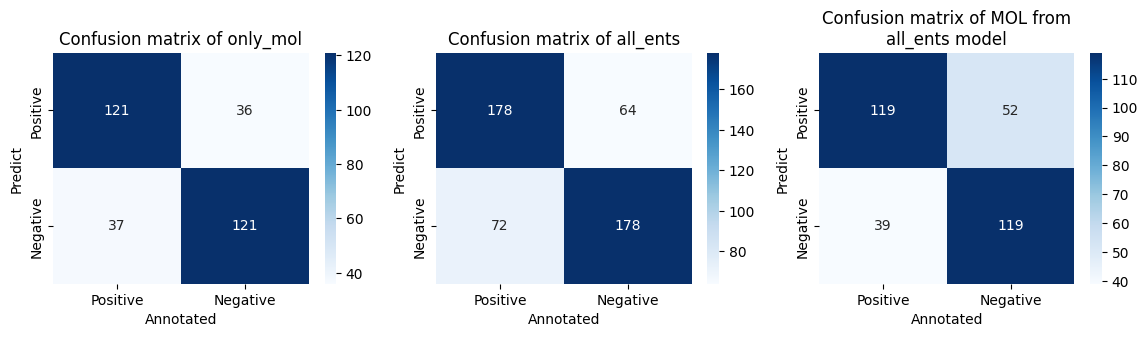

In [42]:
# Convert list of scores into a pd.DataFrame
df_cm = []
for i in range(len(parameters)) :
    df_cm.append(pd.DataFrame(
        [[tp[i], fp[i]], [fn[i], tn[i]]],
        index=["Positive", "Negative"],
        columns=["Positive", "Negative"]
    ))

# Display confusion matrix    
fig, axs = plt.subplots(1, 3, figsize=(14, 3))
for i, parms in enumerate(parameters):
    sns.heatmap(df_cm[i], annot=True, cmap='Blues', fmt='d', ax=axs[i])
    axs[i].set_xlabel('Annotated')
    axs[i].set_ylabel('Predict')
    title = "MOL from\n" + parms[0] + " model" if i == 2 else parms[0]
    axs[i].set_title("Confusion matrix of " +  title)

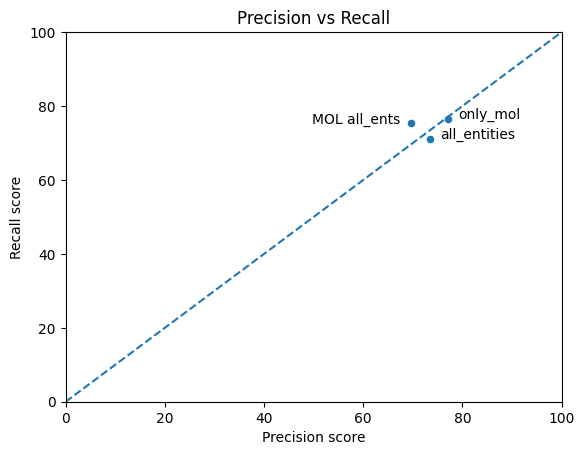

In [52]:
name_models = ["only_mol", "all_entities", "MOL all_ents"]
df = pd.DataFrame({"x":pscores, "y":rscores, "model":name_models})

# Plot different scores
ax = df.plot(kind='scatter', x='x', y='y')
plt.title("Precision vs Recall")
plt.plot([0, 100], [0, 100], linestyle="dashed")
plt.ylim(0, 100)
plt.xlim(0, 100)
plt.xlabel("Precision score")
plt.ylabel("Recall score")

# Label each point in scatter plot
for idx, row in df.iterrows():
    if idx == 2:
        ax.annotate(row['model'], (row['x']-20, row['y']))
    else :
        ax.annotate(row['model'], (row['x'] + 2, row['y']))

### Comparison of models

## Baseline: regular expression

The objective of this part is to compare our model using all entities with regular expressions, more precisely for entities like "STIME" (simulation time) and "TEMP" (temperature) which are easy to extract.

In [91]:
pattern = r"(\d+\.\d+|\d+)\s*([nμm]s)"
path = "../results/colab/all_ents"
ner = spacy.load(path + "/models/model-best/")
nlp = spacy.blank("en")
regex_time = 0
matchs_regex = []
ner_time = 0
matchs_ner = []
true_time = 0
annotated = []

# Read the evaluation dataset
with open(path + "/eval_data.spacy", "rb") as f:
    doc_bin = spacy.tokens.DocBin().from_bytes(f.read())
    
# Get predicted entities and annoted entities
for doc in doc_bin.get_docs(nlp.vocab):
    doc_ner = ner(doc.text)
    matchs = re.findall(pattern, doc.text)
    matchs_regex.extend(matchs)
    regex_time += len(matchs)
    pred_ents = [(ent.text, ent.start_char, ent.end_char, ent.label_) for ent in doc_ner.ents if ent.label_ == "STIME"]
    matchs_ner.extend(pred_ents)
    ner_time += len(pred_ents)
    true_ents = [(ent.text, ent.start_char, ent.end_char, ent.label_) for ent in doc.ents if ent.label_ == "STIME"]
    annotated.extend(true_ents)
    true_time += len(true_ents)
print("NER: ", matchs_ner, "\n")
print("REGEX: ", matchs_regex, "\n")
print("ANNOTATED: ", annotated, "\n")
print("[STIME with NER]:", ner_time, " [STIME with REGEX]:", regex_time, " [STIME annotated]:", true_time)

NER:  [('100ns', 1302, 1307, 'STIME'), ('5 μs', 555, 559, 'STIME'), ('200 ns', 148, 154, 'STIME'), ('100 ns', 466, 472, 'STIME'), ('179 ns.', 683, 690, 'STIME'), ('15 μs', 78, 83, 'STIME'), ('15 μs', 1284, 1289, 'STIME'), ('10 μs', 1291, 1296, 'STIME'), ('5 μs', 1309, 1313, 'STIME'), ('4200 ns', 396, 403, 'STIME'), ('100 ns', 1010, 1016, 'STIME')] 

REGEX:  [('100', 'ns'), ('5', 'μs'), ('200', 'ns'), ('100', 'ns'), ('179', 'ns'), ('21', 'ns'), ('15', 'μs'), ('5', 'μs'), ('5', 'μs'), ('5', 'μs'), ('5', 'μs'), ('15', 'μs'), ('10', 'μs'), ('5', 'μs'), ('4200', 'ns'), ('100', 'ns')] 

ANNOTATED:  [('100ns', 1302, 1307, 'STIME'), ('5 μs', 555, 559, 'STIME'), ('200 ns', 148, 154, 'STIME'), ('179 ns', 683, 689, 'STIME'), ('15 μs', 78, 83, 'STIME'), ('4200 ns', 396, 403, 'STIME')] 

[STIME with NER]: 11  [STIME with REGEX]: 16  [STIME annotated]: 6


## Annex

In [53]:
#--------------------------------------------OUTPUTS--------------------------------------------#

benchmark_command_mol = """ MOL   77.07   76.58   76.83 """
benchmark_command_all = """
================================== Results ==================================

TOK     100.00
NER P   73.55 
NER R   71.20 
NER F   72.36 
SPEED   3554  


=============================== NER (per type) ===============================

             P       R       F
MOL      69.59   75.32   72.34
SOFT     95.00   61.29   74.51
FFM      83.87   59.09   69.33
STIME    45.45   83.33   58.82
TEMP    100.00   81.82   90.00
"""

<Figure size 500x500 with 0 Axes>

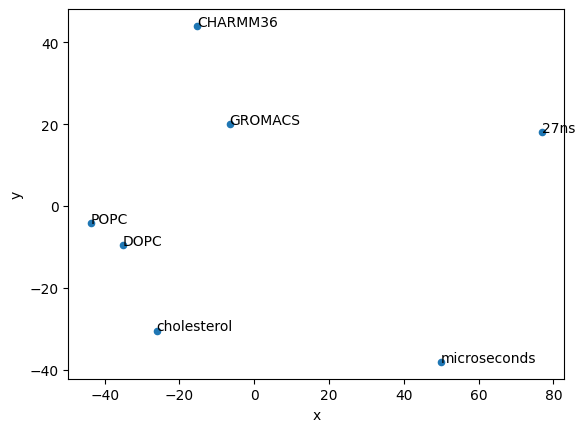

In [39]:
import numpy as np
import spacy
from sklearn.decomposition import PCA

nlp = spacy.load("../results/models_0.4_0.0_0.5_0.5/model-best/")

animals = """POPC DOPC cholesterol GROMACS CHARMM36 microseconds 27ns"""
tokens = nlp(animals)
vocab = animals.split()
vectors = np.vstack([word.vector for word in tokens])

pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(vectors)
embeddings_df = pd.DataFrame({"x":embeddings_2d[:, 0], "y":embeddings_2d[:, 1], "token":vocab})

fig = plt.figure(figsize=(5, 5))

x_axis = embeddings_2d[:, 0]
y_axis = embeddings_2d[:, 1]

ax = embeddings_df.plot(kind='scatter', x='x', y='y')

#label each point in scatter plot
for idx, row in embeddings_df.iterrows():
    ax.annotate(row['token'], (row['x'], row['y']))